## 1.导入依赖包

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras import Model

## 2.导入数据集

In [2]:
train = pd.read_csv('../../data/fashion_train.csv')
test = pd.read_csv('../../data/fashion_test.csv')
print(train.shape, test.shape)

(42000, 785) (28000, 784)


## 3.数据预处理

In [3]:
input_shape = (28, 28, 1)
x = np.array(train.iloc[:, 1:])
y = keras.utils.to_categorical(np.array(train.iloc[:, 0]))
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
print(x_train.shape, y_train.shape)

(33600, 784) (33600, 10)


In [4]:
x_test = np.array(test.iloc[:, 0:])
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
print(x_train.shape, y_train.shape)

(33600, 28, 28, 1) (33600, 10)


In [5]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_val /= 255
x_test /= 255

batch_size = 64
classes = 10
epochs = 5

## 4.建立模型

In [6]:
class ResnetBlock(Model):

    def __init__(self, filters, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path

        self.c1 = Conv2D(filters, (3, 3), strides=strides, padding='same',
                         use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.c2 = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b2 = BatchNormalization()

        if residual_path:
            self.down_c1 = Conv2D(filters, (1, 1), strides=strides,
                                  padding='same', use_bias=False)
            self.down_b1 = BatchNormalization()

        self.a2 = Activation('relu')

    def call(self, inputs):
        residual = inputs
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.c2(x)
        y = self.b2(x)

        if self.residual_path:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)

        out = self.a2(y + residual)
        return out


block_list = [2, 2, 2, 2]
initial_filters = 64
num_blocks = len(block_list)
block_list = block_list
out_filters = initial_filters
blocks = tf.keras.models.Sequential()
for block_id in range(len(block_list)):
    for layer_id in range(block_list[block_id]):
        if block_id != 0 and layer_id == 0:
            block = ResnetBlock(out_filters, strides=2, residual_path=True)
        else:
            block = ResnetBlock(out_filters, residual_path=False)
        blocks.add(block)
    out_filters *= 2

model = tf.keras.models.Sequential([
    Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    blocks,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2())
])

## 5.定义优化器、损失函数和评价指标

In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 6.断点续训

In [8]:
save_path = './checkpoint/inception.ckpt'
if os.path.exists(save_path + '.index'):
    print('model loading')
    model.load_weights(save_path)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=save_path,
                                              save_weights_only=True,
                                              save_best_only=True)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model loading


## 7.训练模型

In [9]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[cp_callback, callback])

Epoch 1/5
525/525 [==============================] - 123s 201ms/step - loss: 0.7257 - accuracy: 0.7829 - val_loss: 2.6478 - val_accuracy: 0.2880
Epoch 2/5
525/525 [==============================] - 57s 104ms/step - loss: 0.4141 - accuracy: 0.8665 - val_loss: 0.4062 - val_accuracy: 0.8625
Epoch 3/5
525/525 [==============================] - 36s 68ms/step - loss: 0.3327 - accuracy: 0.8921 - val_loss: 0.3956 - val_accuracy: 0.8683
Epoch 4/5
525/525 [==============================] - 36s 69ms/step - loss: 0.2868 - accuracy: 0.9054 - val_loss: 0.4175 - val_accuracy: 0.8513
Epoch 5/5
525/525 [==============================] - 38s 72ms/step - loss: 0.2542 - accuracy: 0.9162 - val_loss: 0.3553 - val_accuracy: 0.8870


## 8.预测结果

In [10]:
result = model.predict(x_test)
pred = tf.argmax(result, axis=1)
df = pd.DataFrame(pred, columns=['label'])
df.to_csv(path_or_buf='Submission.csv', index_label='image_id')

## 9.模型损失和准确率可视化

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


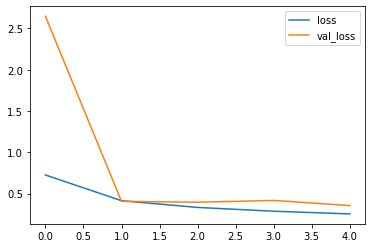

In [12]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()
plt.show()

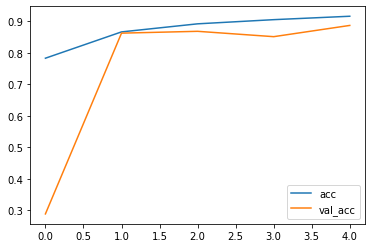

In [13]:
plt.plot(history.epoch, history.history.get('accuracy'), label='acc')
plt.plot(history.epoch, history.history.get('val_accuracy'), label='val_acc')
plt.legend()
plt.show()